In [1]:
#! /usr/bin/python
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from scipy.constants import c, hbar, elementary_charge, Boltzmann
from sklearn import metrics

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.chdir('..')
import utils.utilities as u
import utils.dynamics as d

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from utils.circular_classification_params import *

0.002829421210522584 0.001178912824847821 0.11789128248478209 0.11789128248478209 0.0 0.0035342917352885173 1.178912824847821e-11 1.178912824847821e-09
[8.48e-06 8.48e-05 0.000848 0.00848 0.0848 0.848 8.48 84.8]


In [3]:

LPYD = LPYD[1:,:]                            # Remove first row 
nz = np.nonzero(LPYD[:,2].astype(float))[0]  # Find rows with non-zero probability
LPYD = LPYD[nz,:]                            # Isolate Rows with non-zero probability

DupYLabels = LPYD[:,1]          # Extract the y labels from LPYD (with duplicates)
ylabels = []                    # Remove the duplicates
for i in DupYLabels: 
    if i not in ylabels: 
        ylabels.append(i)

plist = LPYD[:,2].astype(float) # Extract probabilities from LYPD
ptot  = sum(plist)              # Compute their sum
plist = plist/ptot              # Normalize them
cases = len(plist)              # Number of cases being considered

ylist  = LPYD[:,3]  # Extract y-values from LPYD (with duplicates)    
Blist = LPYD[:,4].astype(int)      # Extract Boudary conditions from LPYD
Dlist = LPYD[:,5].astype(int)      # Extract Distances from LPYD
TempList = LPYD[:,6].astype(float) # Extract Distances from LPYD
SmearList = LPYD[:,7] # Extract Distances from LPYD
DimList = LPYD[:,8].astype(int) # Extract Distances from LPYD
if LPYD.shape[1] >= 10:
    LatLenList = LPYD[:,9].astype(int)
else:
    LatLenList = [latlen]*len(DimList)

In [4]:
data_dir = os.getcwd() + "\\Data\\" + experiment_name
try:
    os.mkdir(data_dir)
except FileExistsError:
    pass

In [5]:
# hamiltonian represented by symplectic form F, where F is in basis (q1,..., qN, qD, p1, ..., pN, pD)
Flist_dynamic = [0]*cases         # List of Hamiltonians for dynamics, for each scenario
Flist_thermal = [0]*cases         # List of Hamiltonians for thermality
for k in range(cases):
    Flist_dynamic[k], Flist_thermal[k] = \
        d.get_symplectic_generator(wD,mcc,lam,LatLenList[k],sigma,Blist[k],Dlist[k],dim=DimList[k],smearing=SmearList[k])

False
True


In [6]:
acc = []
val_acc = []
confusion =[]

In [7]:
for t_index in range(len(plot_times_min)):
    tmax = plot_times_max[t_index]
    tmin = plot_times_min[t_index]
    print('Run', t_index, 'of', len(plot_times_max), 'at time', str(np.round(tmin,5)), 'to time', str(np.round(tmax,5)))

    case_time = experiment_name + '_time_'+str(np.round(tmax,5))
    time_dir = data_dir + '\\' + case_time
    try:
        os.mkdir(time_dir)
    except FileExistsError:
        pass

    expdata_name = case_time + '_exp_and_pca_data'
    expdata_dir = time_dir + '\\' + expdata_name
    expdata_exists = False
    pcadata_exists = False
    try:
        os.mkdir(expdata_dir)
    except FileExistsError:
        expdata_exists = os.path.isfile(expdata_dir+'\\exp_data_all.csv')
        pcadata_exists = os.path.isfile(expdata_dir+'\\pca_data_all.csv')
        accdata_exists = os.path.isfile(expdata_dir+'\\acc_data_all.csv')

    if not expdata_exists or overwrite:
        projector_list, median_projector, \
            state_list_0, median_state_0, \
                prepicked_trajectories, median_trajectory, \
                    BigDSList, reglist = \
            u.get_probe_trajectories(
                Flist_dynamic, 
                Flist_thermal, 
                LatLenList,
                Blist, 
                TempList, 
                Tdev, 
                tmin,
                tmax,
                t_index,
                measurements_per_window, 
                cases, 
                n_samples,  
                Regression)
        exp_data = u.generate_measurement_data(
            projector_list, 
            median_projector, 
            prepicked_trajectories, 
            median_state_0, 
            BigDSList,
            cases, 
            n_samples, 
            measurements_per_window, 
            n_tom, 
            Tdev,
            ylist,
            Regression, 
            reglist,
            save=True, 
            path=expdata_dir + '\\')
        
        exp_data = np.asarray(exp_data)
    elif not pcadata_exists:
        print('loading experimental simulation data')
        exp_data = np.asarray(pd.read_csv(expdata_dir+'\\exp_data_all.csv'))

    LO = 1                  # Fraction of variance to be kept after PCA (0 to 1 or 'All') 
    print('Performing PCA')
    if not pcadata_exists or overwrite or not expdata_exists:
        PCAdData = u.run_PCA_on_data(
            exp_data, 
            f_train, 
            PCA_var_keep, 
            cases, 
            save=True, 
            path=expdata_dir + '\\')
    else:
        print('loading PCA data')
        PCAdData = np.asarray(pd.read_csv(expdata_dir+'\\pca_data_all.csv'))
    print('defining model')
    ### DEFINE THE NETWORK ARCHITECTURE ###
    nI = PCAdData.shape[1]-LO
    nO = 1 if Regression else len(ylabels)


    model_list = [
        tf.keras.layers.Flatten(input_shape=(nI,)), 
        tf.keras.layers.Dense(nO, activation=tf.keras.layers.ReLU())]
    if hidden_layer:
        model_list.insert(1, tf.keras.layers.Dense(nH1, activation=tf.keras.layers.ReLU()))
    model = tf.keras.Sequential(model_list)

    def custom_loss_with_l2_reg(lambda_value):
        def loss(y_true, y_pred):
            eps = 10**(-10) # to prevent the logs from diverging
            if Regression:
                cross_entropy = tf.losses.mean_squared_error(y_true,y_pred)
            else:
                cross_entropy = tf.reduce_mean(tf.reduce_sum( -y_true * tf.log(y_pred+eps), reduction_indices=[1]))
            l2_loss = tf.add_n([tf.nn.l2_loss(w) for w in model.trainable_weights])
            return cross_entropy + lambda_value*l2_loss
        return loss

    if True:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-1)
        loss = custom_loss_with_l2_reg(L2reg)

        print('compiling model')
        model.compile(
            optimizer=optimizer, 
            loss=loss, 
            metrics=['mae'] if Regression else ['accuracy'])

        n_train = int(PCAdData.shape[0]*(f_train+f_valid))
        n_test = PCAdData.shape[0] - n_train
        x_train = PCAdData[:n_train, :-LO]
        x_test = PCAdData[n_train:n_train+n_test, :-LO]
        y_train = PCAdData[:n_train, -LO:]
        y_test = PCAdData[n_train:n_train+n_test, -LO:]

        if not Regression:
            y_train_OH = tf.keras.utils.to_categorical(y_train, num_classes=nO)
            y_test_OH = tf.keras.utils.to_categorical(y_test, num_classes=nO)

        print('training model')
        history = model.fit(
            x_train, 
            y_train if Regression else y_train_OH, 
            epochs=6, 
            verbose=1, 
            validation_split=f_valid/(f_valid+f_train), 
            batch_size=minibatch_size)

        if Regression:
            accs = [0.5, 0.25, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]
            y_pred = model.predict(x_test)
            accuracy = [np.sum(np.abs(y_test - y_pred) < acc)/y_test.shape[0] for acc in accs]
            print(accuracy)
            val_acc.append(accuracy)
            if accuracy > 0.999:
                break
        else:
            val_acc.append(history.history['val_acc'][-1])
            print(history.history['val_acc'][-1])
            y_pred = model.predict(x_test)
            confusion.append(metrics.confusion_matrix(y_test_OH.argmax(axis=1), y_pred.argmax(axis=1), labels=list(range(len(ylabels)))))
            print(confusion[-1])


Run 0 of 8 at time 0.0 to time 1e-05
Performing PCA
loading PCA data


defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 0s 22us/sample - loss: 3.8342 - acc: 0.7135 - val_loss: 1.7972 - val_acc: 0.8378
Epoch 2/6
 6400/14999 [===========>..................] - ETA: 0s - loss: 1.3248 - acc: 0.8659

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 9us/sample - loss: 0.7131 - acc: 0.8979 - val_loss: -0.2928 - val_acc: 0.9503
Epoch 3/6
14999/14999 [==============================] - 0s 9us/sample - loss: -0.8910 - acc: 0.9738 - val_loss: -1.3961 - val_acc: 0.9935
Epoch 4/6
14999/14999 [==============================] - 0s 9us/sample - loss: -1.4931 - acc: 0.9965 - val_loss: -1.5710 - val_acc: 0.9987
Epoch 5/6
14999/14999 [==============================] - 0s 10us/sample - loss: -1.6154 - acc: 0.9997 - val_loss: -1.6355 - val_acc: 0.9998
Epoch 6/6
14999/14999 [==============================] - 0s 10us/sample - loss: -1.6590 - acc: 1.0000 - val_loss: -1.6706 - val_acc: 1.0000
1.0
[[519   0]
 [  0 481]]
Run 1 of 8 at time 1e-05 to time 8e-05
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 0s 23us/sample - loss: -0.2645 - acc: 0.9789 - val_loss: -1.4620

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 10us/sample - loss: -1.5742 - acc: 1.0000 - val_loss: -1.6568 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 19us/sample - loss: -1.7030 - acc: 1.0000 - val_loss: -1.7371 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - 0s 14us/sample - loss: -1.7579 - acc: 1.0000 - val_loss: -1.7726 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 11us/sample - loss: -1.7824 - acc: 1.0000 - val_loss: -1.7888 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 10us/sample - loss: -1.7936 - acc: 1.0000 - val_loss: -1.7963 - val_acc: 1.0000
1.0
[[507   0]
 [  0 493]]
Run 2 of 8 at time 8e-05 to time 0.00085
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 0s 32us/sample - loss: 1.3973 - acc: 0.8813 - val_loss: -1

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 14us/sample - loss: -1.3072 - acc: 1.0000 - val_loss: -1.3913 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 11us/sample - loss: -1.4397 - acc: 1.0000 - val_loss: -1.4927 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.5234 - acc: 1.0000 - val_loss: -1.5608 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.5822 - acc: 1.0000 - val_loss: -1.6109 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 22us/sample - loss: -1.6266 - acc: 1.0000 - val_loss: -1.6494 - val_acc: 1.0000
1.0
[[498   0]
 [  0 502]]
Run 3 of 8 at time 0.00085 to time 0.00848
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 0s 33us/sample - loss: -1.0928 - acc: 0.9992 - val_loss:

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 11us/sample - loss: -1.6898 - acc: 1.0000 - val_loss: -1.7429 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.7683 - acc: 1.0000 - val_loss: -1.7831 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.7920 - acc: 1.0000 - val_loss: -1.7962 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 11us/sample - loss: -1.7993 - acc: 1.0000 - val_loss: -1.8001 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.8016 - acc: 1.0000 - val_loss: -1.8018 - val_acc: 1.0000
1.0
[[506   0]
 [  0 494]]
Run 4 of 8 at time 0.00848 to time 0.08482
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 1s 42us/sample - loss: 1.9791 - acc: 0.9051 - val_loss: 

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/6
14999/14999 [==============================] - 0s 28us/sample - loss: -0.8751 - acc: 1.0000 - val_loss: -1.0240 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 19us/sample - loss: -1.1325 - acc: 1.0000 - val_loss: -1.2316 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - ETA: 0s - loss: -1.3067 - acc: 1.00 - 0s 13us/sample - loss: -1.3076 - acc: 1.0000 - val_loss: -1.3772 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.4325 - acc: 1.0000 - val_loss: -1.4832 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 11us/sample - loss: -1.5244 - acc: 1.0000 - val_loss: -1.5618 - val_acc: 1.0000
1.0
[[492   0]
 [  0 508]]
Run 5 of 8 at time 0.08482 to time 0.84824
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 0s 23us/

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 13us/sample - loss: -0.8057 - acc: 1.0000 - val_loss: -0.9146 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 13us/sample - loss: -1.0168 - acc: 1.0000 - val_loss: -1.0850 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.1619 - acc: 1.0000 - val_loss: -1.2067 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.2673 - acc: 1.0000 - val_loss: -1.2971 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.3466 - acc: 1.0000 - val_loss: -1.3668 - val_acc: 1.0000
1.0
[[487   0]
 [  0 513]]
Run 6 of 8 at time 0.84824 to time 8.48239
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
14999/14999 [==============================] - 0s 28us/sample - loss: 3.0458 - acc: 0.8635 - val_loss: 

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 17us/sample - loss: -1.1757 - acc: 1.0000 - val_loss: -1.3264 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.4228 - acc: 1.0000 - val_loss: -1.5091 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.5670 - acc: 1.0000 - val_loss: -1.6200 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.6559 - acc: 1.0000 - val_loss: -1.6893 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.7117 - acc: 1.0000 - val_loss: -1.7330 - val_acc: 1.0000
1.0
[[486   0]
 [  0 514]]
Run 7 of 8 at time 8.48239 to time 84.82391
Performing PCA
loading PCA data
defining model
compiling model
training model
Train on 14999 samples, validate on 4000 samples
Epoch 1/6
12032/14999 [=======================>......] - ETA: 0s - loss: -1.0226 - acc: 1.0000

c:\Users\BCimr\anaconda3\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


14999/14999 [==============================] - 0s 30us/sample - loss: -1.1300 - acc: 1.0000 - val_loss: -1.6059 - val_acc: 1.0000
Epoch 2/6
14999/14999 [==============================] - 0s 14us/sample - loss: -1.6928 - acc: 1.0000 - val_loss: -1.7511 - val_acc: 1.0000
Epoch 3/6
14999/14999 [==============================] - 0s 13us/sample - loss: -1.7723 - acc: 1.0000 - val_loss: -1.7886 - val_acc: 1.0000
Epoch 4/6
14999/14999 [==============================] - 0s 13us/sample - loss: -1.7942 - acc: 1.0000 - val_loss: -1.7991 - val_acc: 1.0000
Epoch 5/6
14999/14999 [==============================] - 0s 12us/sample - loss: -1.8004 - acc: 1.0000 - val_loss: -1.8019 - val_acc: 1.0000
Epoch 6/6
14999/14999 [==============================] - 0s 13us/sample - loss: -1.8021 - acc: 1.0000 - val_loss: -1.8025 - val_acc: 1.0000
1.0
[[503   0]
 [  0 497]]


In [8]:
if not Regression:
    conf = np.zeros((len(confusion[0].flatten()), len(confusion)))
    for i, c in enumerate(confusion):
        conf[:, i] = confusion[i].flatten()

plot_times_max_arr = np.asarray(plot_times_max).reshape((-1, 1)).T
plot_times_min_arr = np.asarray(plot_times_min).reshape((-1, 1)).T
if not Regression:
    val_acc_arr = np.asarray(val_acc).reshape((-1, 1)).T
else:
    val_acc_arr = np.asarray(val_acc).T

output = (plot_times_min_arr, plot_times_max_arr, val_acc_arr) if Regression else (plot_times_min_arr, plot_times_max_arr, val_acc_arr, conf)
test_result = np.concatenate(output, axis=0)

if not os.path.isfile(data_dir+'\\test_output.csv') or overwrite:
    pd.DataFrame(test_result).to_csv(data_dir+'\\test_output.csv')

In [9]:
a, 

(0.0035342917352885173,)

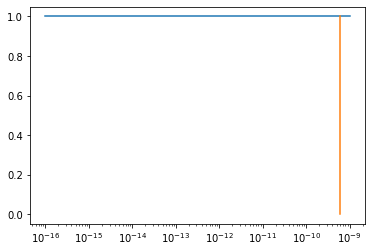

In [10]:
import matplotlib.pyplot as plt

fig, ax=plt.subplots()
ax.plot(plot_times_max*a/3e8, val_acc)
ax.plot([50*a/3e8]*2, [0,1])

ax.set_xscale('log')
#plt.xlim(0, 1)
#plt.ylim(0, 1)

In [11]:
np.printoptions(linewidth=1000, )
k=0
Flist_dynamic[0][:101, :101][:, -1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.118])

In [14]:
for t_index in range(len(plot_times_min[:1])):
    tmax = plot_times_max[t_index]
    tmin = plot_times_min[t_index]

    case_time = experiment_name + '_time_'+str(np.round(tmax,5))
    time_dir = data_dir + '\\' + case_time

    expdata_name = case_time + '_exp_and_pca_data'
    expdata_dir = time_dir + '\\' + expdata_name

    exp_data = np.asarray(pd.read_csv(expdata_dir+'\\exp_data_all.csv'))

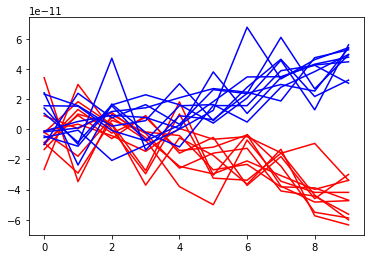

In [25]:
fig, ax = plt.subplots()
idxs = [0,3,6,9,12,15,18,21,24,27]
idxs = np.asarray(idxs)
i=1
for q in exp_data[:10]:
    ax.plot(q[idxs+i], c='red')

for q in exp_data[10000:10010]:
    ax.plot(q[idxs+i], c='blue')
    
# calculate whiteman functions